In [1]:
import numpy as np
from tqdm import tqdm
from echo_lv.data import LV_CAMUS_Dataset, LV_EKB_Dataset
from echo_lv.metrics import dice as dice_np
from echo_lv.utils import AverageMeter
from echo_lv.segmentation.cnn import mUNet

import torch
import torchvision
from torch.utils.data import DataLoader
from torch import sigmoid
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from torchsummary import summary
import segmentation_models_pytorch as smp
import pandas as pd
from apex import amp


device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# device='cpu'
print(device)
torch.cuda.set_device(1)

random_state = 17
torch.manual_seed(random_state)
torch.cuda.manual_seed(random_state)
torch.backends.cudnn.deterministic = True

cuda:1


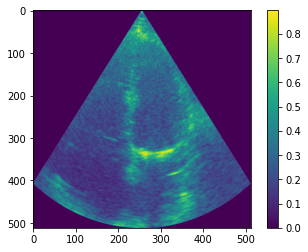

In [2]:
lv_camus = LV_CAMUS_Dataset(img_size = (512,512), classes = {0, 1}, folds=None)
plt.imshow(np.squeeze(lv_camus[10][0]))
plt.colorbar()

In [7]:
batch = 8
epochs = 30
folds = None

lv_camus = LV_CAMUS_Dataset(img_size = (512,512), classes = {0, 1}, folds=folds)
train_loader = DataLoader(lv_camus, batch_size=batch, shuffle=True, num_workers=2)

weight = 10 * torch.ones((1,1,512,512), device=device)
criterion = smp.utils.losses.DiceLoss(activation='sigmoid') + smp.utils.losses.BCEWithLogitsLoss(pos_weight=weight) 
dice = smp.utils.metrics.Fscore(activation='sigmoid', threshold=None).to(device)#Dice()
iou = smp.utils.metrics.IoU(activation='sigmoid', threshold=None).to(device)
result = []

header = True

model = mUNet(in_channels = 1, out_channels = 1, dropout=0.0).to(device)
# model.load_state_dict(torch.load('modified_unet.pth'))

optimizer = torch.optim.Adam([
        {'params': model.parameters(), 'lr': 1e-4, 'betas' : (0.95, 0.99)},   
    ])



scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

t = tqdm(total=epochs, 
        bar_format='{desc} | {postfix[0]}/'+ str(epochs) +' | ' +
        '{postfix[1]} : {postfix[2]:>2.4f} | {postfix[3]} : {postfix[4]:>2.4f} | {postfix[5]} : {postfix[6]:>2.4f} |',
        postfix=[0, 'loss', 0, 'dice_lv', 0,  'jaccard_lv', 0], 
        desc = 'Train modified unet',
        position=0, leave=True
     )            


for epoch in range(0, epochs):
    average_total_loss = AverageMeter()
    average_dice = AverageMeter()
    average_jaccard = AverageMeter()

    model.train()

    t.postfix[0] = epoch + 1
    
    for data in train_loader:
        inputs, masks, *_ = data

        inputs=inputs.to(device).float()
        masks=masks.to(device).float()

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, masks)

        average_total_loss.update(loss.data.item())
        average_dice.update(dice(outputs, masks).item())
        average_jaccard.update(iou(outputs, masks).item())

        loss.backward()
#         with amp.scale_loss(loss, optimizer) as scaled_loss:
#             scaled_loss.backward(retain_graph=True)
        optimizer.step()

        t.postfix[2] = average_total_loss.average()
        t.postfix[4] = average_dice.average()
        t.postfix[6] = average_jaccard.average()
        t.update(n=1)

    result = [optimizer.param_groups[0]['lr'], 
              average_total_loss.average(), 
              average_dice.average(), 
              average_jaccard.average(),
             ]
    df = pd.DataFrame(np.array([result]), columns=['lr', 'loss', 'dice', 'jaccard'])
    df.to_csv('cnn/mod_unet/result.csv', mode='a', header=header, index=False,)
    header=None
    scheduler.step()
#     torch.save(model.state_dict(), 'modified_unet_'+str(epoch)+'.pth')
t.close()

Train modified unet | 30/30 | loss : 0.0646 | dice_lv : 0.9660 | jaccard_lv : 0.9343 |


In [ ]:
torch.save(model.to('cpu').state_dict(), 'modified_unet.pth')

In [ ]:
batch = 8
epochs = 5
folds = None

lv_ekb = LV_EKB_Dataset(img_size = (512,512), normalize=True, only_first_frames=True)
train_loader = DataLoader(lv_ekb, batch_size=batch, shuffle=True, num_workers=2)

weight = 10 * torch.ones((1,1,512,512), device=device)
criterion = smp.utils.losses.DiceLoss(activation='sigmoid').to(device) + smp.utils.losses.BCEWithLogitsLoss(pos_weight=weight) 
dice = smp.utils.metrics.Fscore(activation='sigmoid', threshold=None).to(device)#Dice()
iou = smp.utils.metrics.IoU(activation='sigmoid', threshold=None).to(device)
result = []

header = True

model = mUNet(in_channels = 1, out_channels = 1, dropout=0.0).to(device)
model.load_state_dict(torch.load('modified_unet.pth'))

optimizer = torch.optim.Adam([
        {'params': model.parameters(), 'lr': 1e-4},   
    ])

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

t = tqdm(total=epochs, 
        bar_format='{desc} | {postfix[0]}/'+ str(epochs) +' | ' +
        '{postfix[1]} : {postfix[2]:>2.4f} | {postfix[3]} : {postfix[4]:>2.4f} | {postfix[5]} : {postfix[6]:>2.4f} |',
        postfix=[0, 'loss', 0, 'dice_lv', 0,  'jaccard_lv', 0], 
        desc = 'Train modified unet',
        position=0, leave=True
     )            


for epoch in range(0, epochs):
    average_total_loss = AverageMeter()
    average_dice = AverageMeter()
    average_jaccard = AverageMeter()

    model.train()

    t.postfix[0] = epoch + 1
    
    for data in train_loader:
        inputs, masks, *_ = data

        inputs=inputs.to(device).float()
        masks=masks.to(device).float()

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, masks)

        average_total_loss.update(loss.data.item())
        average_dice.update(dice(outputs, masks).item())
        average_jaccard.update(iou(outputs, masks).item())

        loss.backward()
        optimizer.step()

        t.postfix[2] = average_total_loss.average()
        t.postfix[4] = average_dice.average()
        t.postfix[6] = average_jaccard.average()
        t.update(n=1)

    result = [optimizer.param_groups[0]['lr'], 
              average_total_loss.average(), 
              average_dice.average(), 
              average_jaccard.average(),
             ]
    df = pd.DataFrame(np.array([result]), columns=['lr', 'loss', 'dice', 'jaccard'])
#     df.to_csv('cnn/mod_unet/result.csv', mode='a', header=header, index=False,)
    header=None
    scheduler.step()
t.close()

Dataset is correct.


Train modified unet | 5/5 | loss : 0.0885 | dice_lv : 0.9421 | jaccard_lv : 0.8906 |


In [ ]:
torch.save(model.to('cpu').state_dict(), 'modified_unet_1st_frame.pth')

## Остальное неважно

In [5]:
model = mUNet(1, 1).to(device)
model.load_state_dict(torch.load('modified_unet.pth'))
model.eval();

lv_ekb = LV_EKB_Dataset(img_size=(512,512), shuffle=False, normalize=True)

test_loader = DataLoader(lv_ekb, batch_size=1, shuffle=False, num_workers=2)

criterion = smp.utils.losses.DiceLoss(activation='sigmoid').to(device)# + smp.utils.losses.BCEWithLogitsLoss(pos_weight=weight) 
dice = smp.utils.metrics.Fscore(activation='sigmoid', threshold=0.5).to(device)#Dice()
iou = smp.utils.metrics.IoU(activation='sigmoid', threshold=0.5).to(device)

average_total_loss = AverageMeter()
average_dice = AverageMeter()
average_jaccard = AverageMeter()

t = tqdm(total=len(test_loader), 
        bar_format='{desc} | {postfix[0]}/'+ str(len(test_loader)) +' | ' +
        '{postfix[1]} : {postfix[2]:>2.4f} | {postfix[3]} : {postfix[4]:>2.4f} | {postfix[5]} : {postfix[6]:>2.4f} |',
        postfix=[0, 'loss', 0, 'dice_lv', 0,  'jaccard_lv', 0], 
        desc = 'Test modified unet on USEKB',
        position=0, leave=True
     )

results = {'loss' : [], 'dice' : [], 'jaccard' : []}
i = 1
for data in test_loader:
    inputs, masks, *_ = data

    inputs=inputs.to(device).float()
    masks=masks.to(device).float()

    outputs = model(inputs)

    loss = criterion(outputs, masks)

    l = loss.data.item()
    d = dice(outputs, masks).item()
    j = iou(outputs, masks).item()
    average_total_loss.update(l)
    average_dice.update(d)
    average_jaccard.update(j)
    
    t.postfix[0] = i
    t.postfix[2] = average_total_loss.average()
    t.postfix[4] = average_dice.average()
    t.postfix[6] = average_jaccard.average()
    results['loss'].append(l)
    results['dice'].append(d)
    results['jaccard'].append(j)
    t.update(n=1)
    i += 1
t.close()

Dataset is correct.


Test modified unet on USEKB | 2771/2771 | loss : 0.2812 | dice_lv : 0.8174 | jaccard_lv : 0.7032 |


In [25]:
np.argmin(results['dice'])

1686

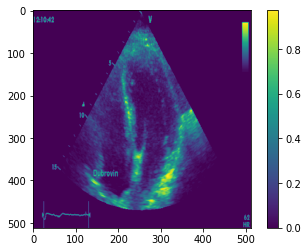

In [43]:
index = np.argmin(results['dice']) + 100
img, msk = lv_ekb[index]
plt.imshow(np.squeeze(img))
plt.colorbar()

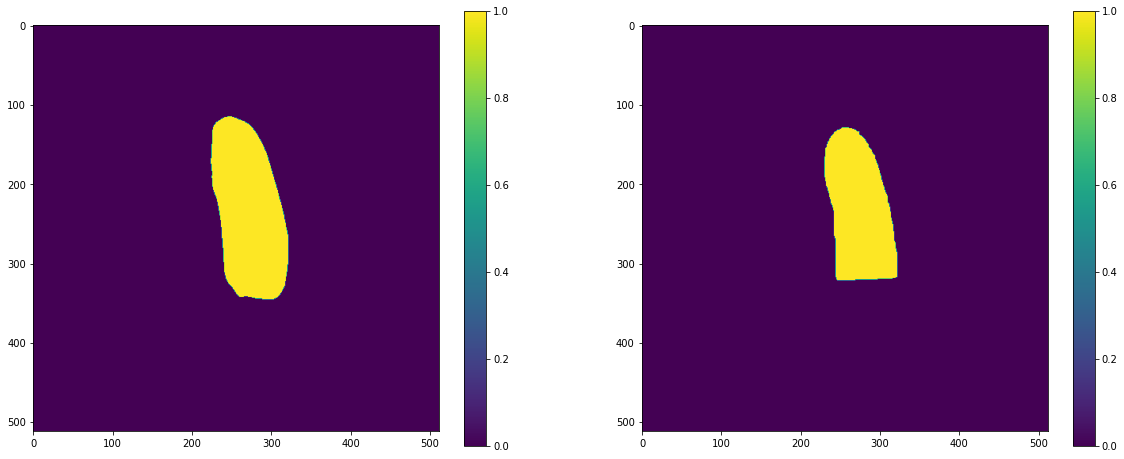

In [48]:
out = model(torch.tensor(np.expand_dims(img, axis = 0)).to(device).float())
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(np.squeeze(out.detach().cpu().numpy() > 1))
plt.colorbar()
plt.subplot(122)
plt.imshow(np.squeeze(msk))
plt.colorbar()

In [45]:
dice(out, torch.tensor(np.expand_dims(msk, axis = 0)).to(device).float())

tensor(0.8747, device='cuda:1')

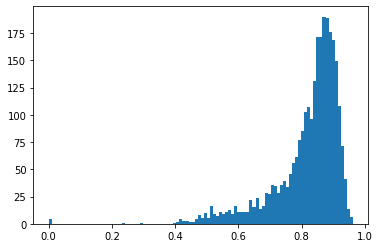

In [37]:
plt.hist(results['dice'], bins=100);

In [ ]:
model = mUNet(in_channels = 1, out_channels = 1).to(device)

In [ ]:
# summary(model, (1, 512, 512), device='cpu')

In [ ]:
folds = 9
lv_camus = LV_CAMUS_Dataset(img_size = (512,512), classes = {0, 1}, folds=folds)
# lv_camus_valid = LV_CAMUS_Dataset(img_size = (572,572), classes = {0, 1}, folds=10, subset='valid')
lv_camus.set_state('train', 0)
train_loader = DataLoader(lv_camus, batch_size=1, shuffle=True, num_workers=4)

In [5]:
lv_camus.set_state('valid', 0)
imgs, msks, *_ = lv_camus[15]
imgs = torch.tensor(np.expand_dims(imgs, axis=0))
msks = torch.tensor(np.expand_dims(msks, axis=0))

# imgs, msks, *_ = next(iter(valid_loader))

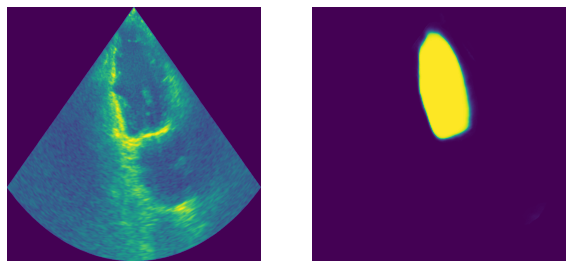

In [9]:
model.eval()
outputs = sigmoid(model(imgs.to(device).float()))
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(imgs[0,0,:,:])
plt.axis('off')
plt.subplot(122)
o = outputs[0,0,:,:].cpu().detach().numpy()
plt.imshow(o)
plt.axis('off')
# plt.subplot(133)
m = msks[0,0,:,:].cpu().detach().numpy()
# plt.imshow(m)

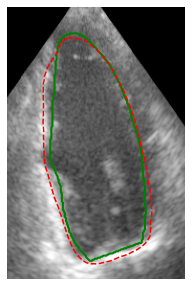

In [10]:
plt.figure(figsize=(5,5))
plt.imshow(imgs[0,0,], cmap = plt.cm.gray)
plt.contour(m, 1, colors='g')
plt.contour(o, 1, colors='r', linestyles='dashed')
plt.axis('off')
plt.xlim(180,350)
plt.ylim(20,280)
plt.gca().invert_yaxis()
plt.savefig('cnn/us_image_res_modified_unet.png', bbox_inches='tight', pad_inches=0,)

In [9]:
dice_np(o, m)

0.10373113814904299

In [10]:
dice = smp.utils.metrics.Fscore(activation='sigmoid', threshold=0)
dice(outputs, msks.to(device))

tensor(0.1037, device='cuda:1', dtype=torch.float64)

In [11]:
criterion = smp.utils.losses.DiceLoss(activation='sigmoid')
criterion(outputs, msks.to(device))

tensor(0.8994, device='cuda:1', dtype=torch.float64, grad_fn=<RsubBackward1>)

In [12]:
lv_camus.set_state(subset='valid', fold=9)
len(lv_camus)

144

In [13]:
lv_camus.set_state(subset='train', fold=9)
len(lv_camus)

1656

In [ ]:
epochs = 3
folds = 9

lv_camus = LV_CAMUS_Dataset(img_size = (512,512), classes = {0, 1}, folds=folds)

# weight = 10 * torch.ones((1,1,512,512), device=device)
criterion = smp.utils.losses.DiceLoss(activation='sigmoid')# + smp.utils.losses.BCEWithLogitsLoss(pos_weight=weight) 
dice = smp.utils.metrics.Fscore(activation='sigmoid', threshold=0.5)#Dice()
iou = smp.utils.metrics.IoU(activation='sigmoid', threshold=0.5)
result = []


for fold in range(0,4):
    header = True
    
    model = mUNet(in_channels = 1, out_channels = 1).to(device)
    
    optimizer = torch.optim.Adam([
            {'params': model.parameters(), 'lr': 1e-4},   
        ])
    
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    
    t = tqdm(total=epochs, 
            bar_format='{desc} | {postfix[0]}/'+ str(epochs) +' | ' +
            '{postfix[1]} : {postfix[2]:>2.4f} | {postfix[3]} : {postfix[4]:>2.4f} | {postfix[5]} : {postfix[6]:>2.4f} |' +
            '{postfix[7]} : {postfix[8]:>2.4f} | {postfix[9]} : {postfix[10]:>2.4f} | {postfix[11]} : {postfix[12]:>2.4f} |',
            postfix=[0, 'loss', 0, 'dice_lv', 0,  'jaccard_lv', 0,
                     'val_loss', 0, 'val_dice_lv', 0, 'val_jaccard_lv', 0], 
            desc = 'Train modified unet on fold ' + str(fold),
            position=0, leave=True
         )            
        
       
    for epoch in range(0, epochs):
        average_total_loss = AverageMeter()
        average_dice = AverageMeter()
        average_jaccard = AverageMeter()
        
        torch.cuda.empty_cache()
        model.train()

        t.postfix[0] = epoch + 1
        
        lv_camus.set_state('train', fold)
        train_loader = DataLoader(lv_camus, batch_size=2, shuffle=True, num_workers=4)
        for data in train_loader:

            torch.cuda.empty_cache()
            inputs, masks, *_ = data

            inputs=inputs.to(device).float()
            masks=masks.to(device).float()

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, masks)

            average_total_loss.update(loss.data.item())
            average_dice.update(dice(outputs, masks).item())
            average_jaccard.update(iou(outputs, masks).item())

            loss.backward()
            optimizer.step()

            t.postfix[2] = average_total_loss.average()
            t.postfix[4] = average_dice.average()
            t.postfix[6] = average_jaccard.average()
            t.update(n=1)

        # validation
        average_val_total_loss = AverageMeter()
        average_val_dice = AverageMeter()
        average_val_jaccard = AverageMeter()
        model.eval()
        
        lv_camus.set_state('valid', fold)
        valid_loader = DataLoader(lv_camus, batch_size=2, shuffle=True, num_workers=2)
        for data in valid_loader:
            inputs, masks, *_ = data

            inputs=inputs.to(device).float()
            masks=masks.to(device).float()

            outputs = model(inputs)

            loss = criterion(outputs, masks)

            average_val_total_loss.update(loss.data.item())
            average_val_dice.update(dice(outputs, masks).item())
            average_val_jaccard.update(iou(outputs, masks).item())

            t.postfix[8] = average_val_total_loss.average()
            t.postfix[10] = average_val_dice.average()
            t.postfix[12] = average_val_jaccard.average()
            t.update(n=0)
        
        result = [average_total_loss.average(), average_dice.average(), average_jaccard.average(),
                  average_val_total_loss.average(), average_val_dice.average(), average_val_jaccard.average()
                 ]
        df = pd.DataFrame(np.array([result]), columns=['loss_' + str(fold), 'dice_' + str(fold), 'jaccard_' + str(fold), 
                                                     'val_loss_' + str(fold), 'val_dice_' + str(fold), 'val_jaccard_' + str(fold)])
        df.to_csv('cnn/mod_unet/result_munet_'+ str(fold) +'.csv', mode='a', header=header, index=False,)
        header=None
    t.close()

Train modified unet on fold 0 | 3/3 | loss : 0.1493 | dice_lv : 0.9078 | jaccard_lv : 0.8335 |val_loss : 0.1594 | val_dice_lv : 0.8816 | val_jaccard_lv : 0.7931 |
Train modified unet on fold 1 | 2/3 | loss : 0.3781 | dice_lv : 0.8659 | jaccard_lv : 0.7693 |val_loss : 0.3846 | val_dice_lv : 0.8669 | val_jaccard_lv : 0.7700 |

In [25]:
torch.save(model.state_dict(), 'modified_unet.pth')